In [1]:
from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
df_train = pd.read_csv('./data/train_10M.csv') 
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [4]:
# MinMaxScaler             : 
# MaxAbsScaler             : 
# StandardScaler           : 
# RobustScaler             : 
# Normalizer               : 
# QuantileTransformer      : 
# PowerTransformer         : 

scaler = 'MinMaxScaler'

In [5]:
df_train = add_features(df_train)
df_train = clean_df(df_train)
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis=1)
df_train, lat_scaler, lon_scaler = scale_gps(df_train, scaler)
df_train = drop_date(df_train)

Old size: 10000000
New size: 9633165


In [6]:
cols = df_train.columns.tolist()
cols.remove('fare_amount')

X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
%%time

model = RandomForestRegressor(n_estimators=50, n_jobs=-1, verbose=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 2.5

print('Score:', math.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2 :', r2_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50building tree 9 of 50
building tree 10 of 50
building tree 11 of 50

building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50building tree 31 of 50

building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed: 22.7min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  38 out of  50 | elapsed:  1.4min remaining:   26.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:  1.5min finished


Score: 3.1734782118747864
R^2 : 0.8878702776336538
CPU times: user 4h 20min 42s, sys: 6min, total: 4h 26min 42s
Wall time: 27min 2s


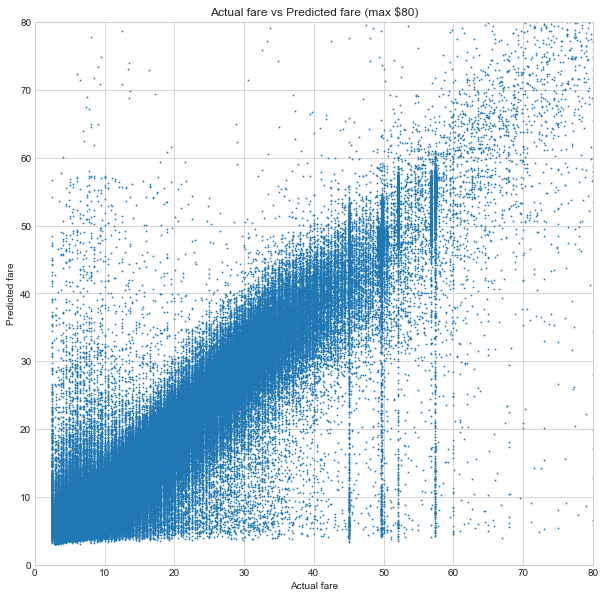

In [8]:
plot_predictions(y_test, y_pred)

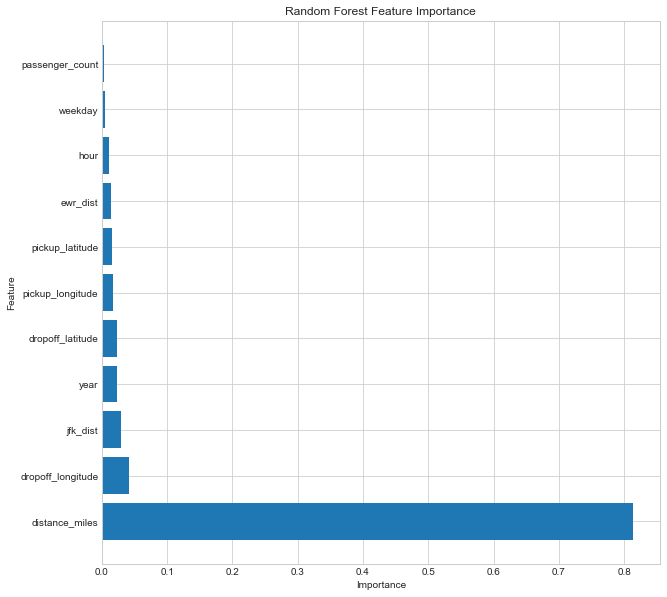

In [9]:
fi = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), cols), reverse=True)

values = [ i[0] for i in fi]
names = [ i[1] for i in fi]

plt.figure(figsize=(10,10))
plt.barh(names, values)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

---

# Creating the Kaggle submission file (prediction on official test set)

In [10]:
df_test = pd.read_csv('./data/test.csv') 
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

df_test = add_features(df_test)
df_test, lat_scaler, lon_scaler = scale_gps(df_test, scaler, lat_scaler, lon_scaler)
df_test = drop_date(df_test)

df_test = df_test.drop(['key'], axis=1)

In [11]:
pred_test = model.predict(df_test)
pred_test[pred_test < 0] = 2.5

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  38 out of  50 | elapsed:   20.4s remaining:    6.4s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:   21.0s finished


In [12]:
df_test = pd.read_csv('./data/test.csv') 

submission = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test.round(2)
})

submission.to_csv('02_2_taxi_fare_submission.csv',index=False)